In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import os
import ipywidgets as widgets

import pyclesperanto_prototype as cle
from scipy import ndimage
from skimage.morphology import binary_closing, binary_opening, disk
from aicsimageio import AICSImage
from apoc import ObjectSegmenter
import napari

In [3]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import plot
from image_analysis.preprocess import mask
from image_analysis.fit import roi

# Preproccesing

In [4]:
from inputs import *

### <span style='color:Red'> [Manual input]  </span>  Image folder

In [5]:
image_folder = r'/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/'

In [6]:
img_paths = get_paths(image_folder, exclude='.lif_', suffix='.lif')
img_paths = change_paths(img_paths, '', 'lifext')
img_paths = change_paths(img_paths, '', 'bleached')
img_paths

['/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/hcr21_20240730_5cm_9d_p_hist_t5b#27.lif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/hcr21_20240730_5cm_9d_noif_t5a#27.lif']

### <span style='color:Red'> [Manual input]  </span>  choose file

In [7]:
i = 1
img_path = img_paths[i]
print(img_path)

/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/hcr21_20240730_5cm_9d_noif_t5a#27.lif


In [8]:
sample = '5cm_9dpa_noif'

In [9]:
image_folder_tif = os.path.join(
    os.path.dirname(img_path), 
    'tif'
)

In [10]:
img_paths = get_paths(image_folder_tif, suffix='tif')
img_paths = change_paths(img_paths, include='noif')
img_paths

['/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c1_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c4_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c3_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c5_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c6_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c2_hcr21_2024

In [11]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('tif/c')[1].split('_')[0]
)

In [12]:
img_paths

['/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c1_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c2_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c3_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c4_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c5_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c6_hcr21_2024

### Load images

In [13]:
#Voxel size: 0.9019x0.9014x4.9998 micron^3

pixel_size_x, pixel_size_y, pixel_size_z = 0.9014, 0.9019, 4.9998

print('physical pixels sizes x, y, z:   ', pixel_size_x, pixel_size_y, pixel_size_z)

pixel_size_z = downsample * pixel_size_z * 1e-6
pixel_size_y = downsample * pixel_size_y * 1e-6
pixel_size_x = downsample * pixel_size_x * 1e-6

pixel_size = np.array([pixel_size_z, -pixel_size_y, pixel_size_x]) # (ez, ey, ex) corresponds k, i, j table indexes

print('downsamples pixels sizes x, y, z:', pixel_size_x, pixel_size_y, pixel_size_z)

physical pixels sizes x, y, z:    0.9014 0.9019 4.9998
downsamples pixels sizes x, y, z: 1.8028e-06 1.8038e-06 9.999599999999998e-06


In [14]:
import tifffile

In [15]:
img = []
for path in img_paths:
    print(path)
    i = tifffile.imread(path)
    #print(i.shape)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c1_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif
/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c2_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif
/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c3_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif
/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c4_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif
/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c5_hcr21_20240730_5cm_9d_noif_t5a#27.lif_hcr21_20240730_5cm_9d_noif_t5a#27_merging_001.tif
/home/natalia/Documents/github_image_analysis/experimental_data/hcr21/5cm/5cm_9d/tif/c6_hcr21_20240730_5cm_9d_noif_t5a#2

In [16]:
img.shape

(6, 30, 522, 1015)

In [17]:
from inputs import channels

In [18]:
channels = list(channels.keys())

In [19]:
channels

['fgf', 'shh', 'bright', 'dapi', 'dusp', 'auto']

In [20]:
img = dict(zip(channels, img))

In [21]:
del img['bright']
#del img['edu']
#del img['shh']
del img['dapi']

### Isotropic

In [22]:
print('make isotropic')

pixel_size_aim = pixel_size_aim_user_def

scaling_x= pixel_size_x/pixel_size_aim
scaling_y= pixel_size_y/pixel_size_aim
scaling_z= pixel_size_z/pixel_size_aim

print('original pixel sizes x y z', pixel_size_x, pixel_size_y, pixel_size_z )
print('scaling facttors x y z', scaling_x, scaling_y, scaling_z)

make isotropic
original pixel sizes x y z 1.8028e-06 1.8038e-06 9.999599999999998e-06
scaling facttors x y z 0.9014 0.9019 4.9998


In [23]:
for key in img:
    img[key] = cle.scale(img[key], None, scaling_x, scaling_y, scaling_z, centered=False, auto_size=True, linear_interpolation=True)
    img[key] = (np.array(img[key])).astype( np.uint16 )

pixel_size = np.array([pixel_size_aim, -pixel_size_aim, pixel_size_aim])

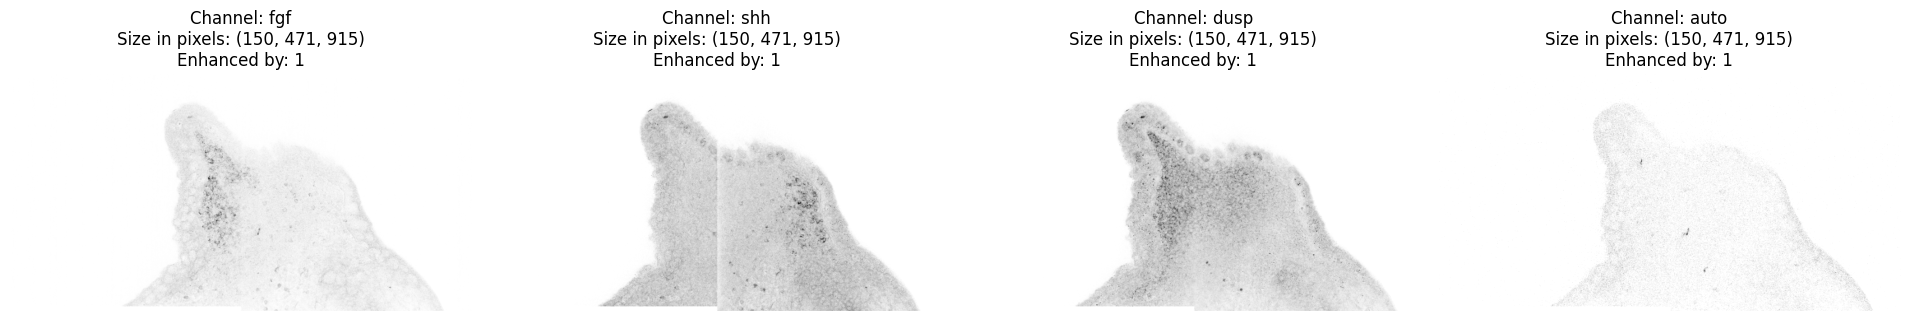

In [24]:
plot.preview(img, 0.5, 1, False, 'none')

# (Rotate) and Crop tissue

In [25]:
for key in img.keys():
    img[key] = np.flip( img[key], 1 )
    img[key] = np.flip( img[key], 2 )

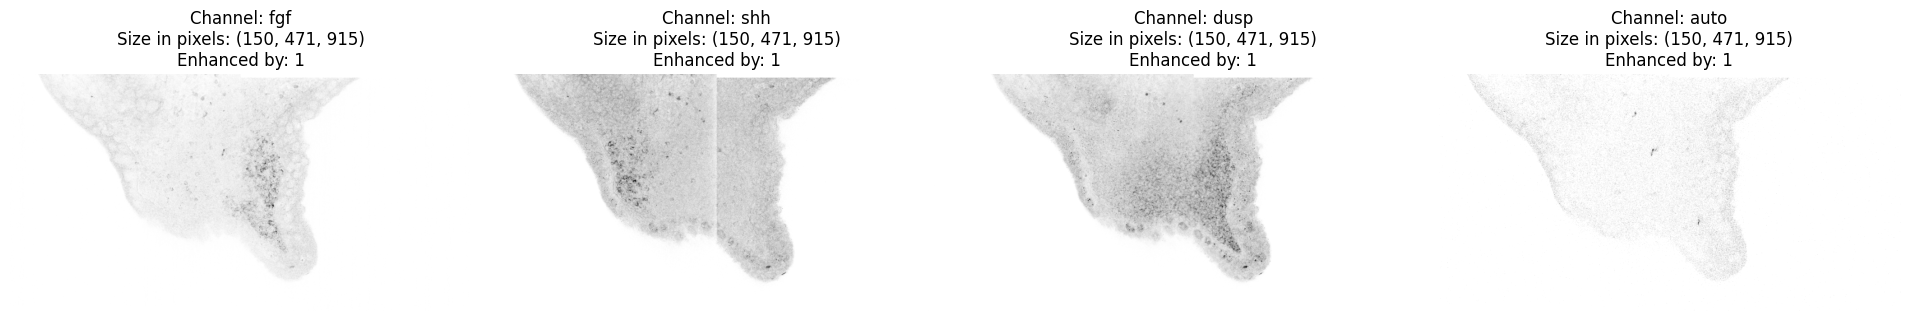

In [26]:
plot.preview(img, 0.5, 1, False, 'none')

## Tissue mask

### <span style='color:Red'> [Manual input]  </span>  Tissue mask name

In [27]:
# make mask name
print('tissue mask name:')
mask_segmeter_path = 'tissue_mask_5cm.cl'#os.path.join( os.path.dirname( img_path ), os.path.splitext( os.path.basename( img_path ) )[0] + '_mask.cl')
print(mask_segmeter_path)

tissue mask name:
tissue_mask_5cm.cl


### <span style='color:Red'> [Manual input]  </span> segment tissue
### brown - outside; blue - line along inside border, brush size - 10 for both

In [28]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=mask_segmeter_path)
result = segmenter.predict(
    image = cle.scale(img['dusp'], None, 0.2, 0.2, 0.2, centered=False, auto_size=True, linear_interpolation=True).astype( np.uint16 )
)
segmentation_lpcm = cle.label_pixel_count_map(result)
#keep only the largest object 
img['tissue_mask'] = (np.where(segmentation_lpcm ==  np.max(segmentation_lpcm), 1, 0)).astype( np.uint16 )

In [29]:
@widgets.interact(z_position = (0, 0.9, 0.1))

def preview_images_z(z_position=0.5):
    z = int(z_position * img['tissue_mask'].shape[0])
    plt.imshow( img['tissue_mask'][ z, :, :], cmap='binary')

interactive(children=(FloatSlider(value=0.5, description='z_position', max=0.9), Output()), _dom_classes=('wid…

In [30]:
j = 0
for i in img['tissue_mask']:
    i[0, :] = 1
    i[:, -1] = 1
    img['tissue_mask'][j, :, :] = ndimage.binary_fill_holes(i)
    j = j + 1

In [31]:
img['tissue_mask'] = mask.morph_change(img['tissue_mask'], 5, True)

In [32]:
img['tissue_mask'] = cle.scale(img['tissue_mask'], None, 5, 5, 5, centered=False, auto_size=True, linear_interpolation=True)
img['tissue_mask'] = np.array(img['tissue_mask'])
k,j,i = img['fgf'].shape
img['tissue_mask'] = img['tissue_mask'][0:k, 0:j, 0:i]
img['tissue_mask'] = (img['tissue_mask'] > 0).astype( np.uint16 )

In [33]:
img['tissue_mask'] = mask.morph_change(img['tissue_mask'], 5, True)

# Epidermis mask

In [34]:
img['epidermis_mask'] = mask.epiderm(img['tissue_mask'], 45, extend_along_z=True)

## Crop only tissue

In [35]:
img = mask.crop(img, img['epidermis_mask'])

Dictionary with 3D data


# Substruct artifacts

In [36]:
print('auto mask name:')

#from inputs import shh_segmenter as segmeter_path

segmeter_path = 'artifacts_5cm_9d_p_hist.cl'#os.path.join( os.path.dirname( img_path ), os.path.splitext( os.path.basename( img_path ) )[0] + '_shh_mask.cl')

print(segmeter_path)

auto mask name:
artifacts_5cm_9d_p_hist.cl


In [37]:
ch_name = 'auto'

In [38]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=segmeter_path)
result = segmenter.predict( image = img[ch_name] )
segmentation_lpcm = cle.label_pixel_count_map(result)

In [39]:
img[ch_name+'_mask'] = (np.where(segmentation_lpcm > 0, 1, 0)).astype( np.uint16 )

In [40]:
img[ch_name+'_clip'] = img[ch_name] * img[ch_name+'_mask']

## Substruct background

In [41]:
import copy
img['tissue_mask_with_epi'] = copy.deepcopy(img['tissue_mask'])
img['tissue_mask']          = img['tissue_mask'] * mask.invert(img['epidermis_mask']) * mask.invert(img['auto_clip'])

In [42]:
for key in img.keys():
    if key.find('mask') < 0:
        img[key] = mask.subtract_bg_clip(img[key], img['tissue_mask'], img['tissue_mask_with_epi'])

Masks for clipping and background subtraction are different.
Mean background value = 163.08712911434375
Masks for clipping and background subtraction are different.
Mean background value = 384.29127904652927
Masks for clipping and background subtraction are different.
Mean background value = 182.74719510025295
Masks for clipping and background subtraction are different.
Mean background value = 369.80263803425015
Masks for clipping and background subtraction are different.
Mean background value = 0


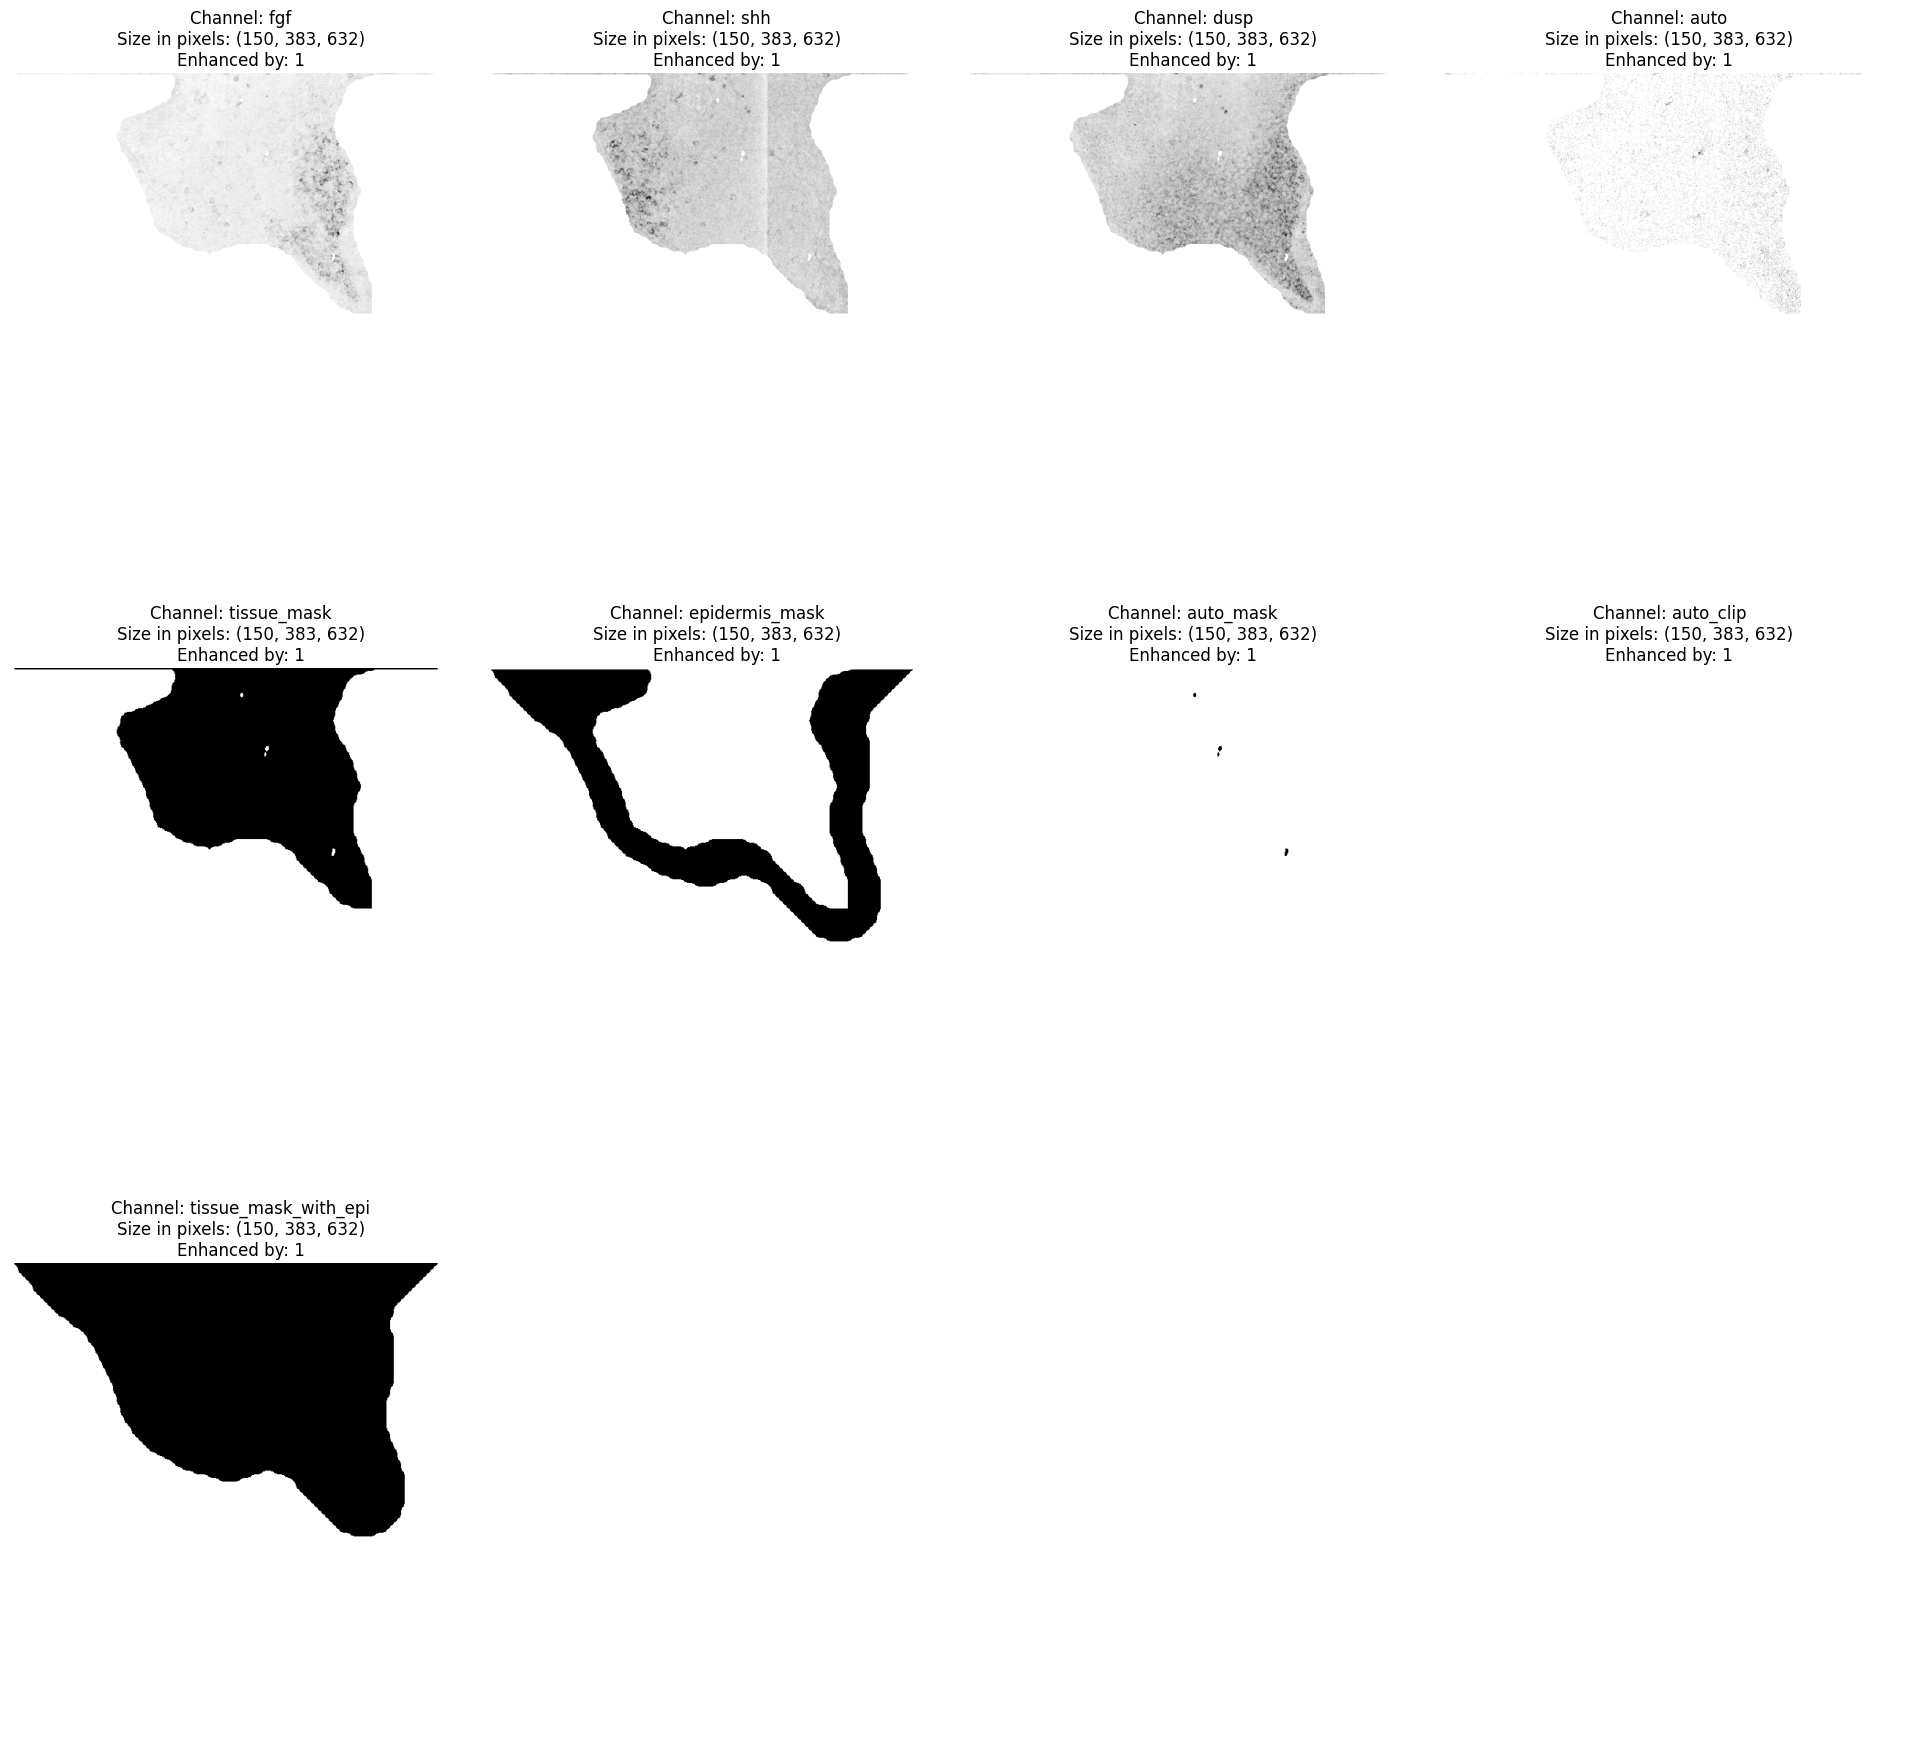

In [43]:
plot.preview(img, 0.5, 1, False, 'none')

## Segment Shh

In [44]:
ch_name = 'shh'

### <span style='color:Red'> [Manual input]  </span> segment Shh

In [45]:
for_mean = copy.deepcopy( img[ch_name] )
for_mean = for_mean.astype(float)
for_mean[for_mean == 0] = np.nan
norm_along_z = np.nanmean( np.nanmean( for_mean[:, 190:210, :370], 1), 1)
norm_along_z = norm_along_z/np.nanmax(norm_along_z)
norm_along_z_broadcasted = norm_along_z[:, np.newaxis, np.newaxis]

/tmp/ipykernel_25681/2421407969.py:4: RuntimeWarning: Mean of empty slice
  norm_along_z = np.nanmean( np.nanmean( for_mean[:, 190:210, :370], 1), 1)


In [46]:
shh_norm = copy.deepcopy( img[ch_name] )
N0 = norm_along_z[np.where(np.isnan(norm_along_z))[0][0]-1]
shh_norm = np.where(np.isnan(norm_along_z_broadcasted), shh_norm/N0, shh_norm / norm_along_z_broadcasted)

In [47]:
image_filtered = np.zeros_like( shh_norm )
image_filtered[:, :, :370] = mask.gfilter( shh_norm[:, :, :370], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.7831996387032675


In [48]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [49]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

## Segment Fgf8

In [50]:
ch_name = 'fgf'

In [51]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.9411498253851448


In [52]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [53]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

## Segment Dusp

In [54]:
ch_name = 'dusp'

In [55]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.8713829536608048


In [56]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [57]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

# Flip and rotate

# Save preprocessed image

In [58]:
img_arr = np.array( [img[key] for key in img.keys()] )
img_arr_keys = np.array( [key for key in img.keys()] )

In [59]:
folder_to_save = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'

In [60]:
file_to_save = f'hcr21_{sample}'
file_to_save

'hcr21_5cm_9dpa_noif'

In [61]:
path_to_save = os.path.join(folder_to_save, file_to_save)

In [62]:
line_to_add = f'{img_path}   {path_to_save}'

info_file_path = os.path.join(folder_to_save, 'original_file_path_pretreated_file_path.txt')

if not os.path.isfile(info_file_path):
    # Create the file if it doesn't exist
    with open(info_file_path, 'w') as file:
        file.write(line_to_add + '\n')
else:
    # Append the line if the file already exists
    with open(info_file_path, 'a') as file:
        file.write(line_to_add + '\n')

In [63]:
np.save( path_to_save, img_arr)

In [64]:
np.save( path_to_save.split('.')[0] + '_keys.npy', img_arr_keys )

In [65]:
np.save( path_to_save.split('.')[0] + '_pixel.npy', pixel_size )